### Import Libraries

In [323]:
# Numeric
import numpy as np
import pandas as pd


# Tools
import os, sys
import re
import string
import csv
import itertools


# # Natural language processing
# import spacy

# from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords as sw
# from nltk.stem.snowball import SnowballStemmer


# Preprocessing and Features engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2



# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering



# Classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline



# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### Some utilities

In [324]:
def print_f1score(scores):
    """Pritn the evaluated f1scores, their mean and standard deviation."""
    print(f"Weighted-f1 for each iteration: {scores}")
    mean_weighted_f1 = scores.mean()
    std_weighted_f1 = scores.std() * 2
    print(f"Weighted-f1 (statistics): {mean_weighted_f1:.3f} (+/- {std_weighted_f1:.3f})")

In [325]:
def write_to_file(filename, labels):
    """Write the evaluated labels to a CSV file."""
    with open(filename, mode='w', encoding='UTF-8') as f:
        fwriter = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        fwriter.writerow(["Id", "Predicted"])
        for Id, label in enumerate(labels):
            fwriter.writerow([Id, label])

### Data exploration

In [326]:
directory = "DSL2122_january_dataset/"
dev_dataset = pd.read_csv(directory + "development.csv")
eval_dataset = pd.read_csv(directory + "evaluation.csv")

print(dev_dataset.iloc[:,0].size)
dev_dataset.head()

224994


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [327]:
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [328]:
print(f"Development dataset size: {dev_dataset['text'].size}")
print(f"Evaluation dataset size: {eval_dataset['text'].size}")

Development dataset size: 224994
Evaluation dataset size: 74999


/tmp/ipykernel_463288/1446544036.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


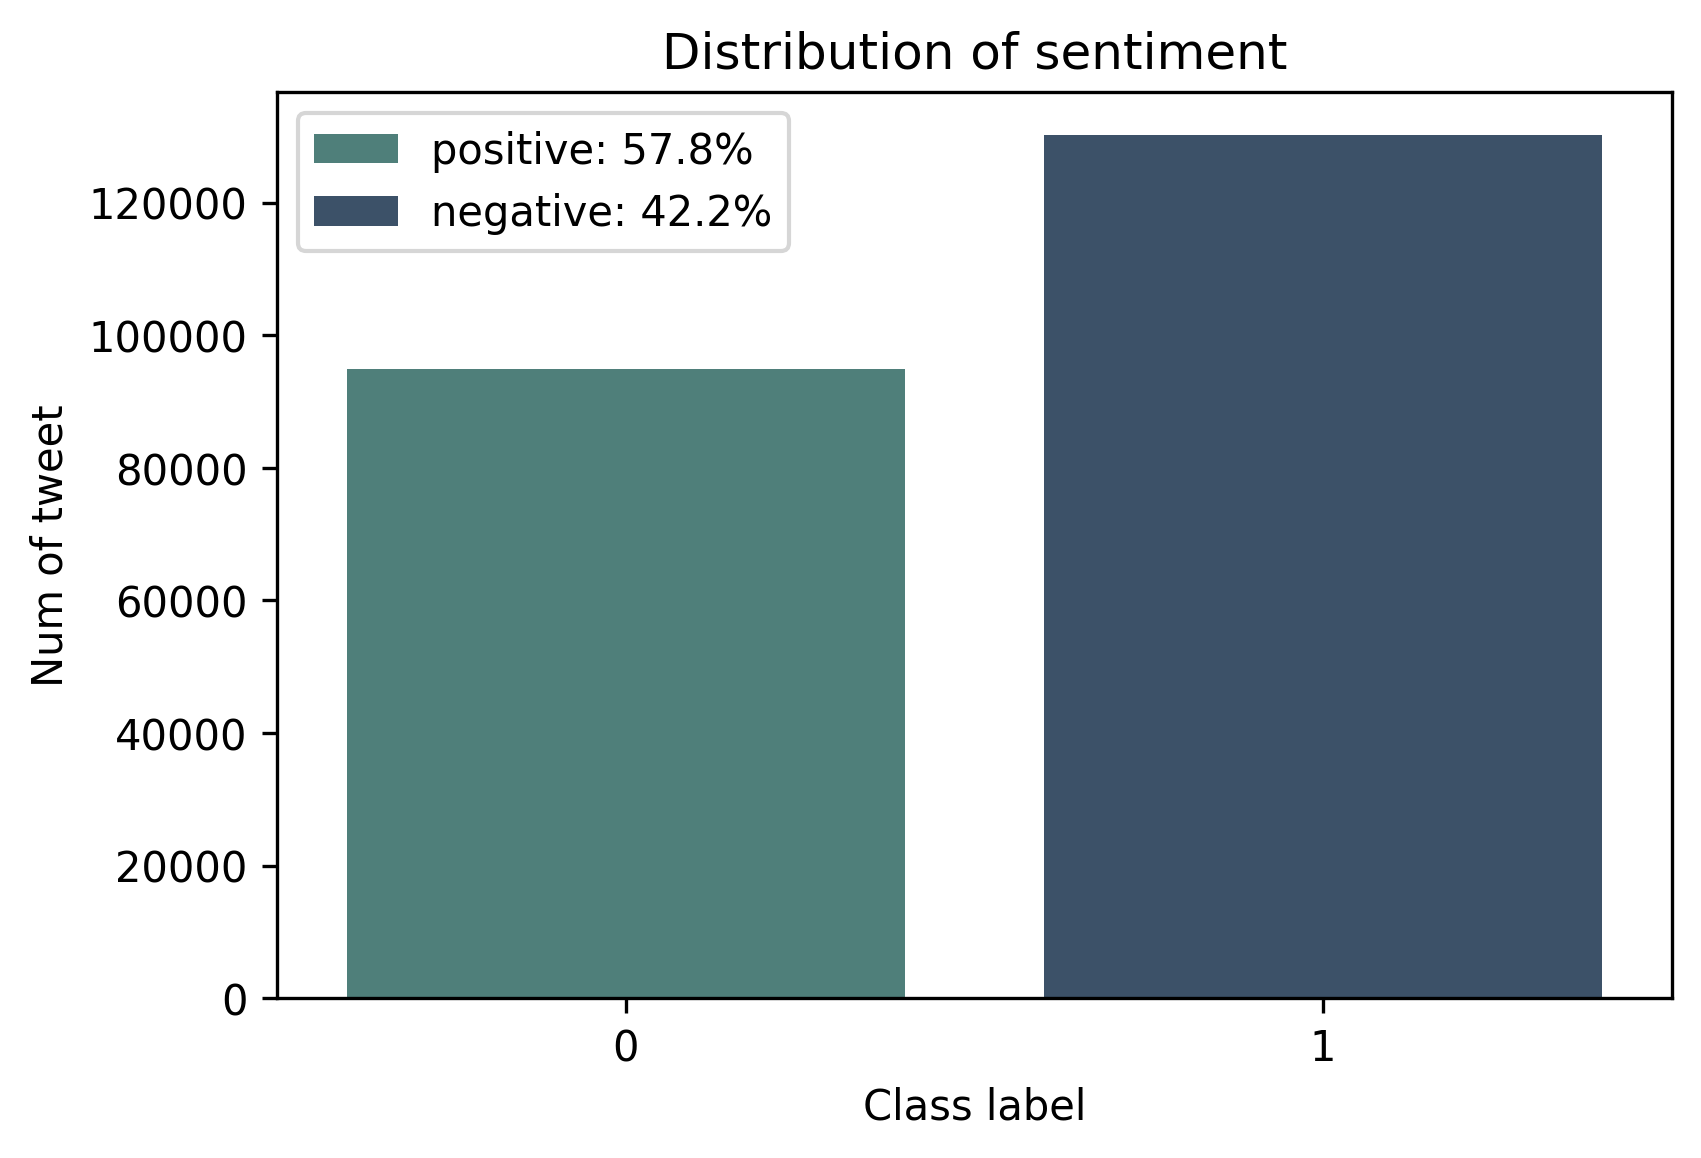

In [329]:

# compute percentages
pos_perc = 100 * dev_dataset[dev_dataset['sentiment'] == 1].size / dev_dataset.size
neg_perc = 100 - pos_perc

fig, ax = plt.subplots(dpi=300)
ax = sns.countplot(x = 'sentiment', data = dev_dataset,
              palette = sns.cubehelix_palette(2, start=.4, rot=-.75, light=.45, dark=.3))
ax.set_ylabel('Num of tweet')
ax.set_xlabel('Class label')
ax.set_title('Distribution of sentiment')
ax.legend(handles=ax.patches, labels=(f'positive: {pos_perc:.1f}%', f'negative: {neg_perc:.1f}%'))
# fig.tight_layout()
fig.show()

### Preprocessing

In [330]:
ds = dev_dataset.copy()
# how many ids are duplicates? around 200
ds.drop_duplicates(['ids'],inplace=True)
print(ds.iloc[:,0].size)

224716


In [331]:
ds = dev_dataset.copy()
# how many flags are there? only one
ds.drop_duplicates(['flag'],inplace=True)
print(ds.iloc[:,0].size)

1


In [332]:
ds = dev_dataset.copy()
# how many user are there? around 10000
ds.drop_duplicates(['user'],inplace=True)
print(ds.iloc[:,0].size)

10647


In [333]:
ds = dev_dataset.copy()
# how many copies of text are there? around 1500
ds.drop_duplicates(['text'],inplace=True)
print(ds.iloc[:,0].size)

223106


In [334]:
#How many nan value there are? 0
ds = dev_dataset.copy()
ds.dropna(subset=['ids', 'user', 'text', 'date', 'flag'])
print("Length of dataframe after NaNs are removed:", len(ds))

Length of dataframe after NaNs are removed: 224994


In [335]:
dev_dataset['text_bis'] = dev_dataset.apply(lambda row: row.text, axis = 1)
df_done = dev_dataset.drop(columns=["flag", "ids", "date"])

eval_dataset['text_bis'] = eval_dataset.apply(lambda row: row.text, axis = 1)
df_eval_done = eval_dataset.drop(columns=["flag", "ids", "date"])

df_done = pd.concat([df_done, df_done])
df_done.head()

,sentiment,user,text,text_bis
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...","@MissBianca76 Yes, talking helps a lot.. going..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,@PleaseBeMine Something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,@GabrielSaporta couldn't get in to the after p...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,@bradiewebbstack awww is andy being mean again...


###  Text processing

In [336]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

def preprocess(textdata):
    processedText = []
    
#     # Create Lemmatizer and Stemmer.
#     wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

#         tweetwords = ''
#         for word in tweet.split():
#             # Checking if the word is a stopword.
#             #if word not in stopwordlist:
#             if len(word)>1:
#                 # Lemmatizing the word.
#                 word = wordLemm.lemmatize(word)
#                 tweetwords += (word+' ')
            
        processedText.append(tweet)
        
    return processedText

In [337]:

import time
t = time.time()
# for tweet in list(dev_dataset['text']):
#     #print(tweet)
# df_done['text'] = preprocess(list(df_done['text']))
# df_done['text_bis'] = preprocess(list(df_done['text_bis']))

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

df_done.head()

Text Preprocessing complete.
Time Taken: 0 seconds


,sentiment,user,text,text_bis
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...","@MissBianca76 Yes, talking helps a lot.. going..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,@PleaseBeMine Something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,@GabrielSaporta couldn't get in to the after p...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,@bradiewebbstack awww is andy being mean again...


In [338]:
df_done.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449988 entries, 0 to 224993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  449988 non-null  int64 
 1   user       449988 non-null  object
 2   text       449988 non-null  object
 3   text_bis   449988 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.2+ MB


### train test split

In [339]:
X = df_done.drop(columns=["sentiment"])
y = df_done["sentiment"]

X.shape, y.shape

((449988, 3), (449988,))

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42, shuffle=True)

### Pipeline

In [341]:
tfidf_params = dict(#sublinear_tf= True, 
                    #use_idf = True,
                    #min_df = 2, 
                    #norm= 'l2', 
                    # token_pattern=r'\b[^\d\W]+\b', #remove number
                    ngram_range= (1,4), 
                    stop_words = stopwordlist)

model = make_pipeline(
        make_column_transformer(
            (TfidfVectorizer(**tfidf_params), "text"),
            (CountVectorizer(ngram_range=(1, 2), binary=True, strip_accents="unicode"), "text_bis"),
            (OneHotEncoder(handle_unknown="ignore"), ["user"]),
            remainder="passthrough"
        ),
        #LogisticRegression(verbose=1, solver='liblinear', random_state=0, C=6, penalty='l2', max_iter=1000, n_jobs=8)
        #MultinomialNB(alpha=0.3),
        LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
        #LinearSVC()
    )
model.fit(X_train, y_train);

# cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# print_f1score(cv_scores)


F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.9447437148427624


In [342]:
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


### ROC curve

[0 1 0 ... 0 1 0]


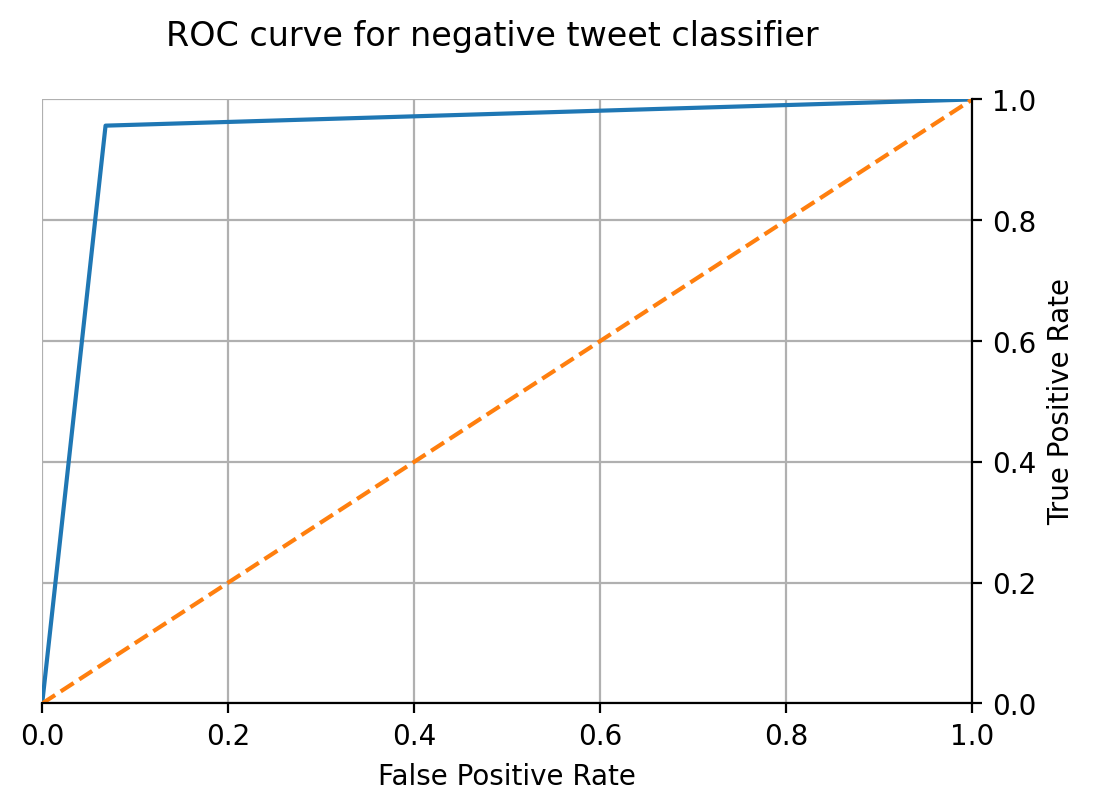

In [343]:
y_score = model.predict(X_test) #[:,1]
print(y_score)

# compute the false positive and true positive rate for the class 'neg'
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(dpi=200)
ax.plot(fpr, tpr)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
fig.suptitle('ROC curve for negative tweet classifier')
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.tick_right()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.yaxis.set_label_position("right")
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed')

### Tuning grid search hyperparameter